In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Concatenate
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from tensorflow.keras.regularizers import l2


output = pd.read_csv("Matrix_R_T5_12Layers.dat", sep='\s+')
data_in1 = pd.read_csv("matrix_SiO2.txt", sep='\s+')
data_in2 = pd.read_csv("matrix_ZnS.txt", sep='\s+')

output = output.to_numpy()

data_in1 = data_in1.to_numpy()
data_in2 = data_in2.to_numpy()

data_in2 = data_in2[:, 1:]  # Eliminamos la primera columna repetida

# Dividir la entrada en longitud de onda y índices de refracción
x_train_wavelength = data_in1[:, 0].reshape(-1, 1)  # Primera columna: longitud de onda
x_train_refractive = np.concatenate((data_in1[:, 1:], data_in2[:, :]), axis=1)  # Índices de refracción


x_train, x_temp, y_train, y_temp = train_test_split(np.concatenate((x_train_wavelength, x_train_refractive), axis=1), output, test_size=0.2, random_state=80)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=80)

y_valid = y_valid[:, 1:]

# Reorganizar los datos para la red neuronal
x_train_wavelength = x_train[:, 0].reshape(-1, 1)
x_train_refractive = x_train[:, 1:].reshape(x_train.shape[0], 2, 2)  # Dos pasos de tiempo, dos características
x_valid_wavelength = x_valid[:, 0].reshape(-1, 1)
x_valid_refractive = x_valid[:, 1:].reshape(x_valid.shape[0], 2, 2)
x_test_wavelength = x_test[:, 0].reshape(-1, 1)
x_test_refractive = x_test[:, 1:].reshape(x_test.shape[0], 2, 2)

#print(x_train_wavelength)
#print("-------------------------------------------")
#print(x_train_refractive[0])

y_train = y_train[:, 1:]

y_test = y_test[:, 1:]

In [2]:
class CustomModel(Model):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.dense_wavelength = Dense(2, activation='relu', kernel_regularizer=l2(0))
        self.rnn_refractive = SimpleRNN(66, activation='relu', kernel_regularizer=l2(0))
        self.dense_concat = Dense(226, activation='relu', kernel_regularizer=l2(0))
        self.dense_output = Dense(4, kernel_regularizer=l2(0))

    def call(self, inputs):
        input_wavelength, input_refractive = inputs
        x_wavelength = self.dense_wavelength(input_wavelength)
        x_refractive = self.rnn_refractive(input_refractive)
        x_concat = Concatenate()([x_wavelength, x_refractive])
        x = self.dense_concat(x_concat)
        return self.dense_output(x)

# Crear y compilar el modelo
model = CustomModel()
model.compile(optimizer='adam', loss='mean_squared_error')

r2_test_values = []
loss_values= []
validation_values=[]


for epoch in range(1200):
    history = model.fit([x_train_wavelength, x_train_refractive], y_train, validation_data=([x_valid_wavelength, x_valid_refractive], y_valid), verbose=False)
    loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    y_pred_test = model.predict([x_test_wavelength, x_test_refractive])
    r2_test = r2_score(y_test, y_pred_test)
    r2_test_values.append(r2_test)
    loss_values.append(loss)
    validation_values.append(val_loss)
    print(f'Epoch {epoch + 1}, Loss: {loss}, Validation Loss: {val_loss}, Test R²: {r2_test}')

12/12 [==============================] - 0s 3ms/step
Epoch 1, Loss: 21.68464469909668, Validation Loss: 0.6855623126029968, Test R²: -31.04958752916513
12/12 [==============================] - 0s 3ms/step
Epoch 2, Loss: 0.1207856610417366, Validation Loss: 0.031073829159140587, Test R²: -1.2003567348489914
12/12 [==============================] - 0s 4ms/step
Epoch 3, Loss: 0.021572303026914597, Validation Loss: 0.019841531291604042, Test R²: -0.6412634331546555
12/12 [==============================] - 0s 3ms/step
Epoch 4, Loss: 0.01864091493189335, Validation Loss: 0.018121087923645973, Test R²: -0.13792262982530062
12/12 [==============================] - 0s 3ms/step
Epoch 5, Loss: 0.017651230096817017, Validation Loss: 0.017347773537039757, Test R²: -0.10116117322258492
12/12 [==============================] - 0s 3ms/step
Epoch 6, Loss: 0.016760660335421562, Validation Loss: 0.016595494002103806, Test R²: 0.16596132067512065
12/12 [==============================] - 0s 4ms/step
Epoch 

12/12 [==============================] - 0s 4ms/step
Epoch 53, Loss: 0.013208974152803421, Validation Loss: 0.013991831801831722, Test R²: -0.24763257937481478
12/12 [==============================] - 0s 3ms/step
Epoch 54, Loss: 0.013056165538728237, Validation Loss: 0.011069816537201405, Test R²: 0.17263622649957336
12/12 [==============================] - 0s 3ms/step
Epoch 55, Loss: 0.012634280137717724, Validation Loss: 0.010664976201951504, Test R²: 0.19810615372814183
12/12 [==============================] - 0s 3ms/step
Epoch 56, Loss: 0.012067372910678387, Validation Loss: 0.011133949272334576, Test R²: 0.13118363818104226
12/12 [==============================] - 0s 4ms/step
Epoch 57, Loss: 0.012449290603399277, Validation Loss: 0.010638639330863953, Test R²: 0.27496533471280055
12/12 [==============================] - 0s 3ms/step
Epoch 58, Loss: 0.011620325967669487, Validation Loss: 0.01030496135354042, Test R²: 0.40403916223649805
12/12 [==============================] - 0s 4m

12/12 [==============================] - 0s 3ms/step
Epoch 105, Loss: 0.015748415142297745, Validation Loss: 0.017794622108340263, Test R²: -0.8467172884918095
12/12 [==============================] - 0s 3ms/step
Epoch 106, Loss: 0.01657458022236824, Validation Loss: 0.01185695081949234, Test R²: 0.21661265011749822
12/12 [==============================] - 0s 3ms/step
Epoch 107, Loss: 0.01796477660536766, Validation Loss: 0.015973065048456192, Test R²: -2.1661150563643523
12/12 [==============================] - 0s 3ms/step
Epoch 108, Loss: 0.023668447509407997, Validation Loss: 0.014804919250309467, Test R²: 0.11179835292277415
12/12 [==============================] - 0s 3ms/step
Epoch 109, Loss: 0.016477802768349648, Validation Loss: 0.01346724946051836, Test R²: -0.7251284926818251
12/12 [==============================] - 0s 4ms/step
Epoch 110, Loss: 0.0148112578317523, Validation Loss: 0.017781594768166542, Test R²: 0.15927287776410454
12/12 [==============================] - 0s 3m

12/12 [==============================] - 0s 2ms/step
Epoch 157, Loss: 0.013065182603895664, Validation Loss: 0.010271964594721794, Test R²: 0.4049971844170126
12/12 [==============================] - 0s 4ms/step
Epoch 158, Loss: 0.01439096312969923, Validation Loss: 0.011269886046648026, Test R²: 0.10088668879006352
12/12 [==============================] - 0s 4ms/step
Epoch 159, Loss: 0.012215490452945232, Validation Loss: 0.015155206434428692, Test R²: -0.5028104692512859
12/12 [==============================] - 0s 3ms/step
Epoch 160, Loss: 0.022793618962168694, Validation Loss: 0.014319384470582008, Test R²: 0.22749813250291429
12/12 [==============================] - 0s 3ms/step
Epoch 161, Loss: 0.015420136973261833, Validation Loss: 0.02243603579699993, Test R²: -0.17504937817871394
12/12 [==============================] - 0s 4ms/step
Epoch 162, Loss: 0.01603453978896141, Validation Loss: 0.011925923638045788, Test R²: 0.14390313250102685
12/12 [==============================] - 0s

12/12 [==============================] - 0s 3ms/step
Epoch 209, Loss: 0.012744924984872341, Validation Loss: 0.013074756599962711, Test R²: 0.003408809648392519
12/12 [==============================] - 0s 4ms/step
Epoch 210, Loss: 0.012891986407339573, Validation Loss: 0.019680632278323174, Test R²: 0.03609447945454761
12/12 [==============================] - 0s 3ms/step
Epoch 211, Loss: 0.012261614203453064, Validation Loss: 0.011492248624563217, Test R²: 0.18225749342967476
12/12 [==============================] - 0s 3ms/step
Epoch 212, Loss: 0.011310109868645668, Validation Loss: 0.010141526348888874, Test R²: 0.40719665485654166
12/12 [==============================] - 0s 3ms/step
Epoch 213, Loss: 0.010929714888334274, Validation Loss: 0.010422909632325172, Test R²: 0.376389001606078
12/12 [==============================] - 0s 3ms/step
Epoch 214, Loss: 0.011465313844382763, Validation Loss: 0.010774239897727966, Test R²: 0.3790762047909796
12/12 [==============================] - 0

12/12 [==============================] - 0s 4ms/step
Epoch 261, Loss: 0.01032375730574131, Validation Loss: 0.009686843492090702, Test R²: 0.40712433961852174
12/12 [==============================] - 0s 3ms/step
Epoch 262, Loss: 0.009919848293066025, Validation Loss: 0.009720204398036003, Test R²: 0.41270204433763724
12/12 [==============================] - 0s 3ms/step
Epoch 263, Loss: 0.009686315432190895, Validation Loss: 0.009345450438559055, Test R²: 0.45234779916153484
12/12 [==============================] - 0s 3ms/step
Epoch 264, Loss: 0.009612969122827053, Validation Loss: 0.009564883075654507, Test R²: 0.43562372638649793
12/12 [==============================] - 0s 3ms/step
Epoch 265, Loss: 0.0099606579169631, Validation Loss: 0.00980619341135025, Test R²: 0.4310774929580999
12/12 [==============================] - 0s 4ms/step
Epoch 266, Loss: 0.009642105549573898, Validation Loss: 0.008992398157715797, Test R²: 0.46417558521880226
12/12 [==============================] - 0s 4

12/12 [==============================] - 0s 3ms/step
Epoch 313, Loss: 0.005362402647733688, Validation Loss: 0.005306941457092762, Test R²: 0.5711993207195201
12/12 [==============================] - 0s 4ms/step
Epoch 314, Loss: 0.005201059393584728, Validation Loss: 0.004439658485352993, Test R²: 0.7466958362630292
12/12 [==============================] - 0s 3ms/step
Epoch 315, Loss: 0.005033029709011316, Validation Loss: 0.005103774834424257, Test R²: 0.5639762583879757
12/12 [==============================] - 0s 3ms/step
Epoch 316, Loss: 0.005731075070798397, Validation Loss: 0.005511085968464613, Test R²: 0.6898762965262522
12/12 [==============================] - 0s 3ms/step
Epoch 317, Loss: 0.005345186218619347, Validation Loss: 0.004140079952776432, Test R²: 0.7565972789993858
12/12 [==============================] - 0s 3ms/step
Epoch 318, Loss: 0.005389929749071598, Validation Loss: 0.004285850562155247, Test R²: 0.7315146867998131
12/12 [==============================] - 0s 3m

12/12 [==============================] - 0s 3ms/step
Epoch 365, Loss: 0.004077900666743517, Validation Loss: 0.0035845411475747824, Test R²: 0.6876786908466168
12/12 [==============================] - 0s 3ms/step
Epoch 366, Loss: 0.003815645584836602, Validation Loss: 0.005297862458974123, Test R²: 0.5768575937076061
12/12 [==============================] - 0s 4ms/step
Epoch 367, Loss: 0.0035854249726980925, Validation Loss: 0.003255727468058467, Test R²: 0.8128349484606785
12/12 [==============================] - 0s 4ms/step
Epoch 368, Loss: 0.004238869063556194, Validation Loss: 0.004832576494663954, Test R²: 0.0842573124501089
12/12 [==============================] - 0s 3ms/step
Epoch 369, Loss: 0.00410743011161685, Validation Loss: 0.0039466568268835545, Test R²: 0.7573452957541542
12/12 [==============================] - 0s 3ms/step
Epoch 370, Loss: 0.0037131092976778746, Validation Loss: 0.0035748276859521866, Test R²: 0.7976764361637558
12/12 [==============================] - 0

12/12 [==============================] - 0s 4ms/step
Epoch 467, Loss: 0.0025321280118077993, Validation Loss: 0.0026266707573086023, Test R²: 0.7873191008310434
12/12 [==============================] - 0s 3ms/step
Epoch 468, Loss: 0.0026095847133547068, Validation Loss: 0.0022452236153185368, Test R²: 0.8246780495422886
12/12 [==============================] - 0s 3ms/step
Epoch 469, Loss: 0.0032250885851681232, Validation Loss: 0.0034350526984781027, Test R²: 0.7771681203426534
12/12 [==============================] - 0s 3ms/step
Epoch 470, Loss: 0.0026294507551938295, Validation Loss: 0.002486596815288067, Test R²: 0.8376375501722823
12/12 [==============================] - 0s 2ms/step
Epoch 471, Loss: 0.0026356340385973454, Validation Loss: 0.0021770319435745478, Test R²: 0.8571087867401974
12/12 [==============================] - 0s 3ms/step
Epoch 472, Loss: 0.003081114497035742, Validation Loss: 0.0030903401784598827, Test R²: 0.7916655632223618
12/12 [=============================

12/12 [==============================] - 0s 3ms/step
Epoch 569, Loss: 0.0021800072863698006, Validation Loss: 0.001924389973282814, Test R²: 0.8703516197290649
12/12 [==============================] - 0s 3ms/step
Epoch 570, Loss: 0.0022526560351252556, Validation Loss: 0.002752459142357111, Test R²: 0.7348723510269115
12/12 [==============================] - 0s 3ms/step
Epoch 571, Loss: 0.002549135824665427, Validation Loss: 0.0017860548105090857, Test R²: 0.854476327130809
12/12 [==============================] - 0s 3ms/step
Epoch 572, Loss: 0.0019831464160233736, Validation Loss: 0.0026535915676504374, Test R²: 0.8578333010230411
12/12 [==============================] - 0s 3ms/step
Epoch 573, Loss: 0.0022548821289092302, Validation Loss: 0.001974557526409626, Test R²: 0.7554476548130415
12/12 [==============================] - 0s 3ms/step
Epoch 574, Loss: 0.0020700411405414343, Validation Loss: 0.0021716365590691566, Test R²: 0.8552713794856875
12/12 [==============================] 

12/12 [==============================] - 0s 3ms/step
Epoch 671, Loss: 0.0014269790844991803, Validation Loss: 0.0020547297317534685, Test R²: 0.8436109981515856
12/12 [==============================] - 0s 3ms/step
Epoch 672, Loss: 0.0015256534097716212, Validation Loss: 0.0013809062074869871, Test R²: 0.9072428890656518
12/12 [==============================] - 0s 3ms/step
Epoch 673, Loss: 0.0015755193307995796, Validation Loss: 0.001531527959741652, Test R²: 0.8752312264916448
12/12 [==============================] - 0s 3ms/step
Epoch 674, Loss: 0.001697676838375628, Validation Loss: 0.002228435128927231, Test R²: 0.8135592519752114
12/12 [==============================] - 0s 3ms/step
Epoch 675, Loss: 0.0017755326116457582, Validation Loss: 0.0024638271424919367, Test R²: 0.8484644065043445
12/12 [==============================] - 0s 4ms/step
Epoch 676, Loss: 0.0014127616304904222, Validation Loss: 0.001301968703046441, Test R²: 0.9162642510940763
12/12 [==============================]

12/12 [==============================] - 0s 3ms/step
Epoch 773, Loss: 0.0013611939502879977, Validation Loss: 0.0013527919072657824, Test R²: 0.7807597163582718
12/12 [==============================] - 0s 3ms/step
Epoch 774, Loss: 0.0010419086320325732, Validation Loss: 0.0007896149181760848, Test R²: 0.9395394389187627
12/12 [==============================] - 0s 3ms/step
Epoch 775, Loss: 0.0014299039030447602, Validation Loss: 0.0010533359600231051, Test R²: 0.929977986441914
12/12 [==============================] - 0s 3ms/step
Epoch 776, Loss: 0.0011450458550825715, Validation Loss: 0.0008367570699192584, Test R²: 0.9467196654288557
12/12 [==============================] - 0s 3ms/step
Epoch 777, Loss: 0.0010639295214787126, Validation Loss: 0.0015937124844640493, Test R²: 0.873197667158619
12/12 [==============================] - 0s 4ms/step
Epoch 778, Loss: 0.0011416594497859478, Validation Loss: 0.0007854913710616529, Test R²: 0.9498034624170951
12/12 [=============================

12/12 [==============================] - 0s 3ms/step
Epoch 875, Loss: 0.0007419707253575325, Validation Loss: 0.0005472801858559251, Test R²: 0.950214325951449
12/12 [==============================] - 0s 3ms/step
Epoch 876, Loss: 0.0007266426109708846, Validation Loss: 0.0012772376649081707, Test R²: 0.7627430383353485
12/12 [==============================] - 0s 4ms/step
Epoch 877, Loss: 0.0007455790764652193, Validation Loss: 0.00045125314500182867, Test R²: 0.9555032051089241
12/12 [==============================] - 0s 3ms/step
Epoch 878, Loss: 0.0005976764368824661, Validation Loss: 0.0006255985354073346, Test R²: 0.8989091840495993
12/12 [==============================] - 0s 3ms/step
Epoch 879, Loss: 0.0008646210771985352, Validation Loss: 0.0005085499142296612, Test R²: 0.9581986457398203
12/12 [==============================] - 0s 4ms/step
Epoch 880, Loss: 0.0010145476553589106, Validation Loss: 0.0017066197469830513, Test R²: 0.8428374297540002
12/12 [===========================

12/12 [==============================] - 0s 3ms/step
Epoch 926, Loss: 0.0006145392544567585, Validation Loss: 0.0005591798108071089, Test R²: 0.9653911534918395
12/12 [==============================] - 0s 4ms/step
Epoch 927, Loss: 0.0005627389764413238, Validation Loss: 0.00048017993685789406, Test R²: 0.9593481067703327
12/12 [==============================] - 0s 3ms/step
Epoch 928, Loss: 0.0005034367786720395, Validation Loss: 0.00046140566701069474, Test R²: 0.9637514282844034
12/12 [==============================] - 0s 3ms/step
Epoch 929, Loss: 0.0006101067992858589, Validation Loss: 0.0005989837809465826, Test R²: 0.9537684291702178
12/12 [==============================] - 0s 2ms/step
Epoch 930, Loss: 0.0006222352385520935, Validation Loss: 0.0008788559352979064, Test R²: 0.9400804911915739
12/12 [==============================] - 0s 4ms/step
Epoch 931, Loss: 0.0005152793019078672, Validation Loss: 0.000425833510234952, Test R²: 0.9269599260254474
12/12 [==========================

12/12 [==============================] - 0s 3ms/step
Epoch 977, Loss: 0.0009006835171021521, Validation Loss: 0.0004092961025889963, Test R²: 0.9701120945304794
12/12 [==============================] - 0s 2ms/step
Epoch 978, Loss: 0.0008942724671214819, Validation Loss: 0.0005941589479334652, Test R²: 0.9329670179149709
12/12 [==============================] - 0s 3ms/step
Epoch 979, Loss: 0.0006512958789244294, Validation Loss: 0.0003121820918750018, Test R²: 0.975624622065241
12/12 [==============================] - 0s 3ms/step
Epoch 980, Loss: 0.0006440694560296834, Validation Loss: 0.0006262076203711331, Test R²: 0.9604618311578659
12/12 [==============================] - 0s 2ms/step
Epoch 981, Loss: 0.0005990297649987042, Validation Loss: 0.00047226191964000463, Test R²: 0.9351171513668954
12/12 [==============================] - 0s 3ms/step
Epoch 982, Loss: 0.0006313787889666855, Validation Loss: 0.0006730834720656276, Test R²: 0.9640596622412919
12/12 [===========================

12/12 [==============================] - 0s 4ms/step
Epoch 1028, Loss: 0.00030615300056524575, Validation Loss: 0.0004172525950707495, Test R²: 0.9693283639856302
12/12 [==============================] - 0s 3ms/step
Epoch 1029, Loss: 0.0004886728711426258, Validation Loss: 0.00034092337591573596, Test R²: 0.974694558400225
12/12 [==============================] - 0s 3ms/step
Epoch 1030, Loss: 0.0003387361066415906, Validation Loss: 0.0003165923117194325, Test R²: 0.9687733142388129
12/12 [==============================] - 0s 3ms/step
Epoch 1031, Loss: 0.0009679410723038018, Validation Loss: 0.001077738357707858, Test R²: 0.9252735640669498
12/12 [==============================] - 0s 2ms/step
Epoch 1032, Loss: 0.0007224975852295756, Validation Loss: 0.0006326090078800917, Test R²: 0.9624442630963606
12/12 [==============================] - 0s 3ms/step
Epoch 1033, Loss: 0.00038560261600650847, Validation Loss: 0.00043756485683843493, Test R²: 0.968445687013906
12/12 [====================

12/12 [==============================] - 0s 3ms/step
Epoch 1079, Loss: 0.0009455694817006588, Validation Loss: 0.00046149984700605273, Test R²: 0.9599213201510676
12/12 [==============================] - 0s 3ms/step
Epoch 1080, Loss: 0.0004290857177693397, Validation Loss: 0.0003919298469554633, Test R²: 0.9689821515326817
12/12 [==============================] - 0s 4ms/step
Epoch 1081, Loss: 0.0002467976592015475, Validation Loss: 0.00021200768242124468, Test R²: 0.9805572388554408
12/12 [==============================] - 0s 4ms/step
Epoch 1082, Loss: 0.0002826288982760161, Validation Loss: 0.0002842459362000227, Test R²: 0.9808747353640058
12/12 [==============================] - 0s 3ms/step
Epoch 1083, Loss: 0.0002747683902271092, Validation Loss: 0.0004874316218774766, Test R²: 0.9621967434554869
12/12 [==============================] - 0s 3ms/step
Epoch 1084, Loss: 0.0002002983819693327, Validation Loss: 0.00019382353639230132, Test R²: 0.9838828929206853
12/12 [==================

12/12 [==============================] - 0s 3ms/step
Epoch 1130, Loss: 0.00032751925755292177, Validation Loss: 0.00032802129862830043, Test R²: 0.9809975427226344
12/12 [==============================] - 0s 3ms/step
Epoch 1131, Loss: 0.0003262087993789464, Validation Loss: 0.0011344758095219731, Test R²: 0.9309940233030566
12/12 [==============================] - 0s 3ms/step
Epoch 1132, Loss: 0.0004749014915432781, Validation Loss: 0.00018465235189069062, Test R²: 0.9876027396653805
12/12 [==============================] - 0s 3ms/step
Epoch 1133, Loss: 0.00026821167557500303, Validation Loss: 0.00026109948521479964, Test R²: 0.9428856307535903
12/12 [==============================] - 0s 3ms/step
Epoch 1134, Loss: 0.0003141188935842365, Validation Loss: 0.0004449744301382452, Test R²: 0.9601446895744131
12/12 [==============================] - 0s 3ms/step
Epoch 1135, Loss: 0.00042606439092196524, Validation Loss: 0.00028557938640005887, Test R²: 0.9807297396597098
12/12 [==============

Epoch 1180, Loss: 0.0006038046558387578, Validation Loss: 0.001197086414322257, Test R²: 0.9095388903385584
12/12 [==============================] - 0s 4ms/step
Epoch 1181, Loss: 0.00037457968574017286, Validation Loss: 0.00023232641979120672, Test R²: 0.9615559770520167
12/12 [==============================] - 0s 3ms/step
Epoch 1182, Loss: 0.0003196691977791488, Validation Loss: 0.000273718498647213, Test R²: 0.9680982841224652
12/12 [==============================] - 0s 3ms/step
Epoch 1183, Loss: 0.00047088865539990366, Validation Loss: 0.0009951600804924965, Test R²: 0.9004001431770245
12/12 [==============================] - 0s 3ms/step
Epoch 1184, Loss: 0.0008643886540085077, Validation Loss: 0.0005004382110200822, Test R²: 0.9734523593273652
12/12 [==============================] - 0s 4ms/step
Epoch 1185, Loss: 0.0005383616662584245, Validation Loss: 0.00036187958903610706, Test R²: 0.9756562621651999
12/12 [==============================] - 0s 3ms/step
Epoch 1186, Loss: 0.000236

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper")

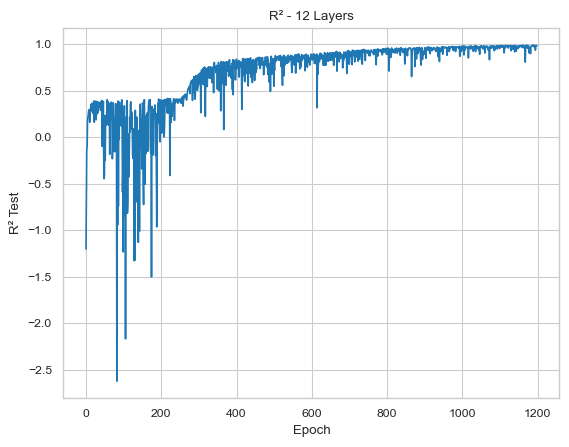

In [4]:
# Graficar el R² del conjunto de prueba al final de cada época
import matplotlib.pyplot as plt
plt.plot(r2_test_values[1:])
plt.xlabel('Epoch')
plt.ylabel('R² Test')
plt.title('R² - 12 Layers')
plt.savefig("R2_12Layers.png", dpi=600)
plt.show()

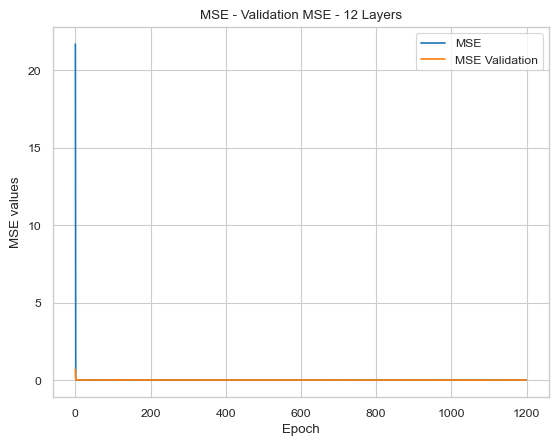

In [15]:
plt.plot(loss_values, label='MSE')
plt.plot(validation_values, label='MSE Validation')
plt.xlabel('Epoch')
plt.ylabel('MSE values')
plt.title('MSE - Validation MSE - 12 Layers')
plt.legend()

plt.savefig("Loss_12Layers.png", dpi=600)
plt.show()

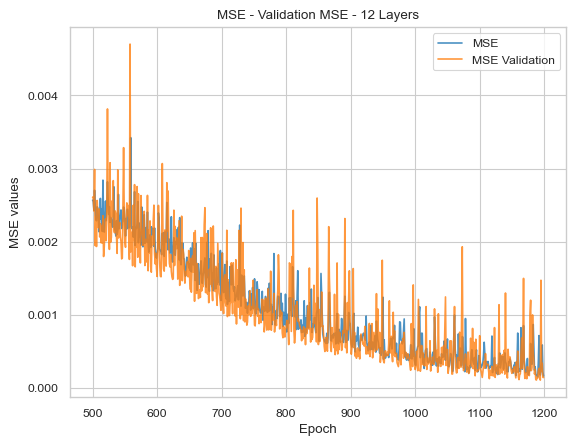

In [16]:
plt.plot(np.arange(500, 1200), loss_values[500:], label='MSE', alpha=0.8)
plt.plot(np.arange(500, 1200),validation_values[500:], label='MSE Validation', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MSE values')
plt.title('MSE - Validation MSE - 12 Layers')
plt.legend()

#plt.savefig("Loss_12Layers_lastEpochs.png", dpi=600)
plt.show()

In [31]:
save_txt = np.concatenate((x_test_wavelength, y_test, predic), axis=1)
#print(save_txt)
df = pd.DataFrame(save_txt)
df.to_csv("matrixPredi12L.txt", sep=' ', index=False)